In [221]:
%config InlineBackend.figure_formats = ['svg']
import quimb
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt

from functions_numpy import *

In [222]:
# Define Dl string of observables
def Ommd(n, sigma):
    """
    Building the observable Dl for a given sigma and n. The standard name for the indexes are k1, k2, ..., kn, b1, b2, ..., bn.
    """
    # Set parameters:
    n = 9             # number of qubits per half
    L = 2 * n         # total number of sites

    Dl_list = []
    # Questa è la sommatoria di tutti i Dl con il loro coefficiente coef1
    for l in range(1, n+1):
        p_sigma = (1 - np.exp(-1/(2*sigma)))/2
        coef = p_sigma**l * (1-p_sigma)**(n-l)

        A_l = A(n, l)

        # Building D2l
        mpo_list = []
        for i in A_l:
            site1 = i
            site2 = site1 + n

            # Define operators:
            Z = np.array([[1, 0],
                        [0, -1]])
            I = np.eye(2)

            # Build MPO tensors: each tensor is shaped (1, 1, 2, 2)
            mpo_tensors = []
            for site in range(L):
                # Choose Z on the designated sites, I elsewhere:
                op = Z if site in site1 or site in site2 else I
                tensor = op.reshape(1, 2, 2) if site in [0, L - 1] else op.reshape(1, 1, 2, 2)
                mpo_tensors.append(tensor)

            # Create the MPO. Here, 'sites' and 'L' help label the tensor network.
            mpo = qtn.MatrixProductOperator(
                mpo_tensors,
                sites=range(L),
                L=L,
                shape='lrud'
            )
            mpo_list.append(mpo)

        # Sum all the MPOs
        Dl = mpo_list[0]
        for i in mpo_list[1:]:
            Dl = Dl.add_MPO(i)
        
        Dl_list.append(coef*Dl)

    O = Dl_list[0]
    for i in Dl_list[1:]:
        Dl = Dl.add_MPO(i)
    
    return Dl

In [223]:
def MMD(x, y,Ommd, sigma, number_open_index, bond_dimension):
    """
    samples and target are two Matrix Product States.
    """

    x /= x.H @ x
    y /= y.H @ y
    rename_dict = {f'k{i}': f'k{i+number_open_index}' for i in range(number_open_index)}
    y.reindex_(rename_dict)

    """
    Building the MMD MPO. The default open indexes are k1, k2, ..., kn, b1, b2, ..., bn.
    Then we can contract the MPO with the MPS and the bitstring state to get the loss function.
    """

    x.add_tag('x')
    y.add_tag('y')
    Ommd.add_tag('Ommd')

    loss = x & Ommd & y

    qtn.drawing.draw_tn(loss, color={"x": "blue", "Ommd": "red", "y": "green"}, figsize=(30, 30), show_inds=True)

    # Here we should do the trace but we have a MPS, what happends then??
    loss = loss @ loss.H
    

    return loss


dimension of dataset: 14

In [224]:
L = 9
D = 8
sigma = 0.09

# create a random MPS as our initial target to optimize
psi = qtn.MPS_rand_state(L, bond_dim=D)
Ommd = Ommd(L, sigma)
dataset = get_bars_and_stripes(3)

In [225]:
MPS_dataset = []
for data in dataset:
    MPS_dataset.append(qtn.MPS_computational_state(data))


In [226]:
def loss_fn(psi,dataset,Ommd):
    loss = 0
    #for data in dataset:
        #loss += MMD(psi, data, Ommd, sigma, L, D)
    #loss = loss / len(dataset)
    loss = MMD(psi, dataset[0], Ommd, sigma, L, D)
    return loss


In [227]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    psi,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    #norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"dataset": MPS_dataset, "Ommd": Ommd},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    # which gradient computation backend to use
    autodiff_backend="numpy",
)

  0%|          | 0/10 [00:00<?, ?it/s]

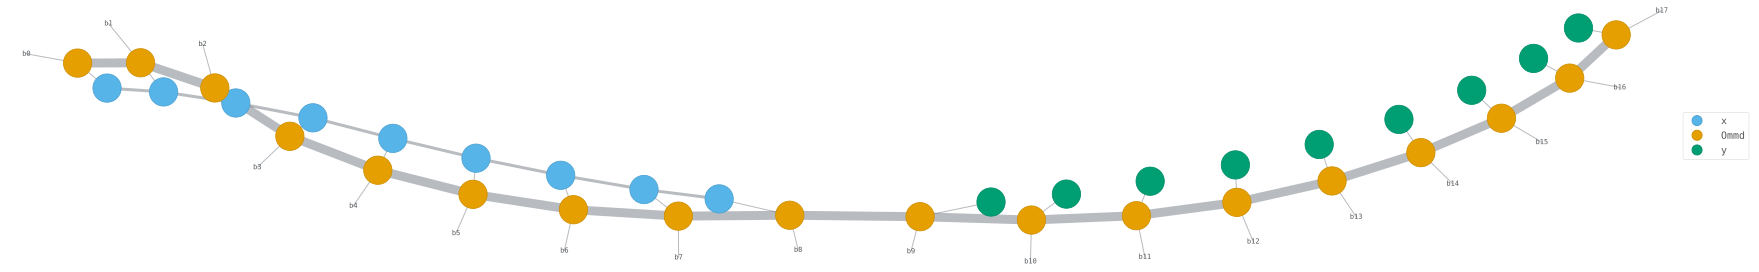

+0.240995199814 [best: +0.240995199814] :  10%|█         | 1/10 [00:01<00:09,  1.05s/it]

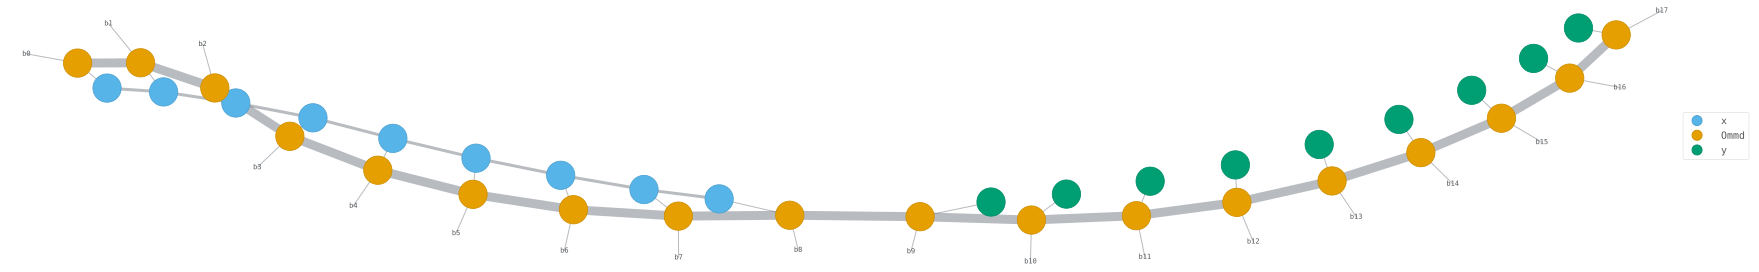

+0.197224055796 [best: +0.197224055796] :  20%|██        | 2/10 [00:02<00:08,  1.05s/it]

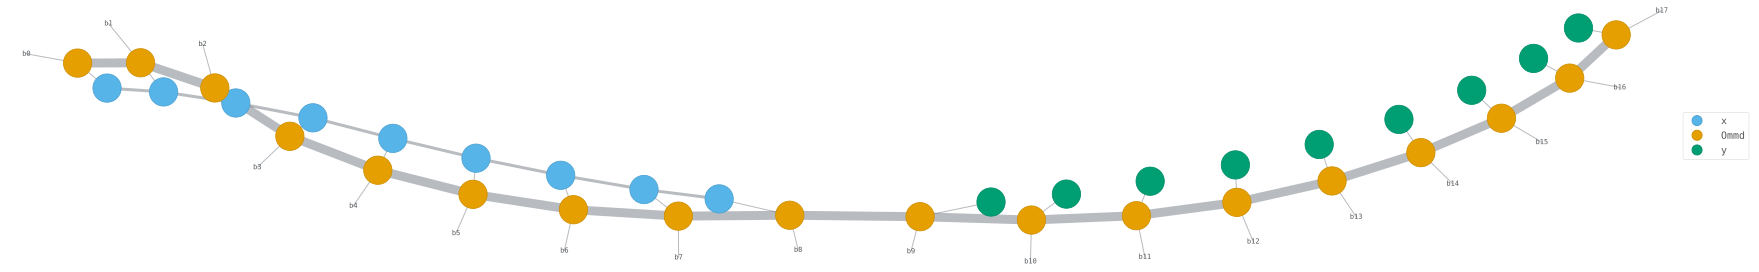

+0.161749941296 [best: +0.161749941296] :  30%|███       | 3/10 [00:03<00:07,  1.11s/it]

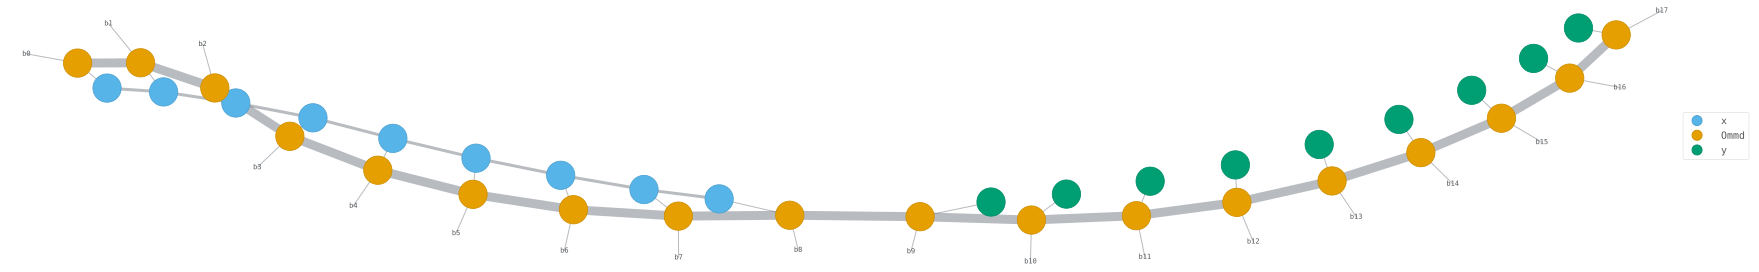

+0.133108838884 [best: +0.133108838884] :  40%|████      | 4/10 [00:04<00:06,  1.11s/it]

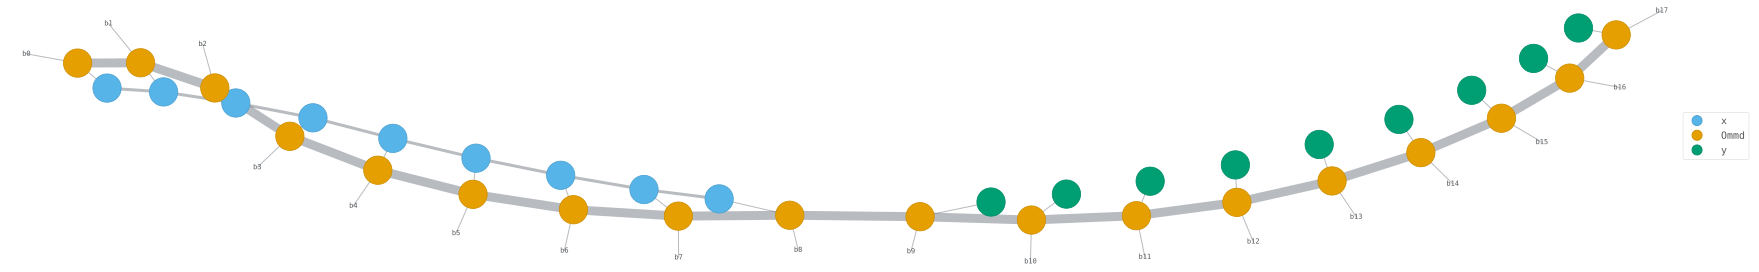

+0.110028658846 [best: +0.110028658846] :  50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

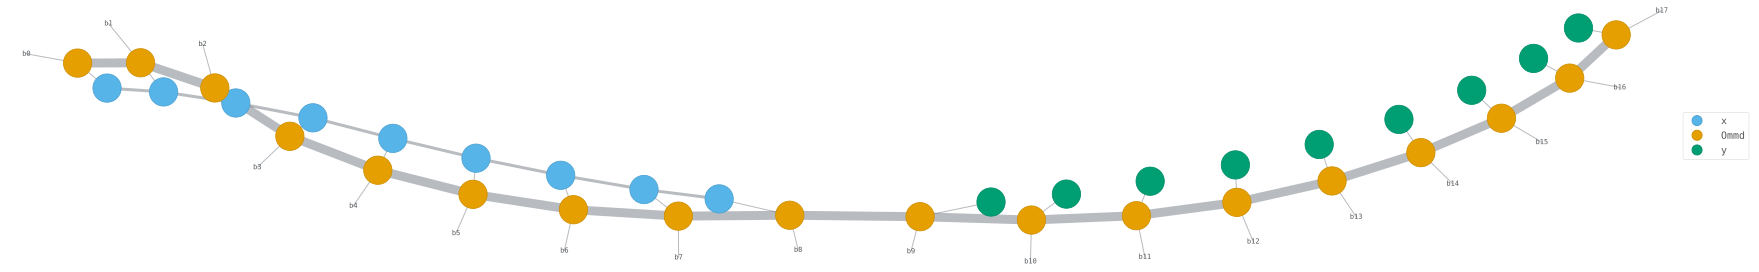

+0.091432906561 [best: +0.091432906561] :  60%|██████    | 6/10 [00:06<00:04,  1.08s/it]

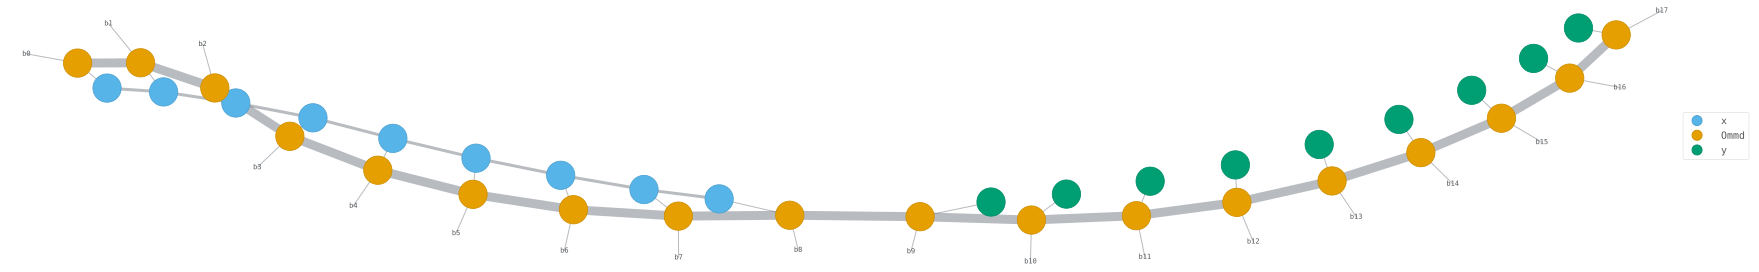

+0.076430376532 [best: +0.076430376532] :  70%|███████   | 7/10 [00:07<00:03,  1.06s/it]

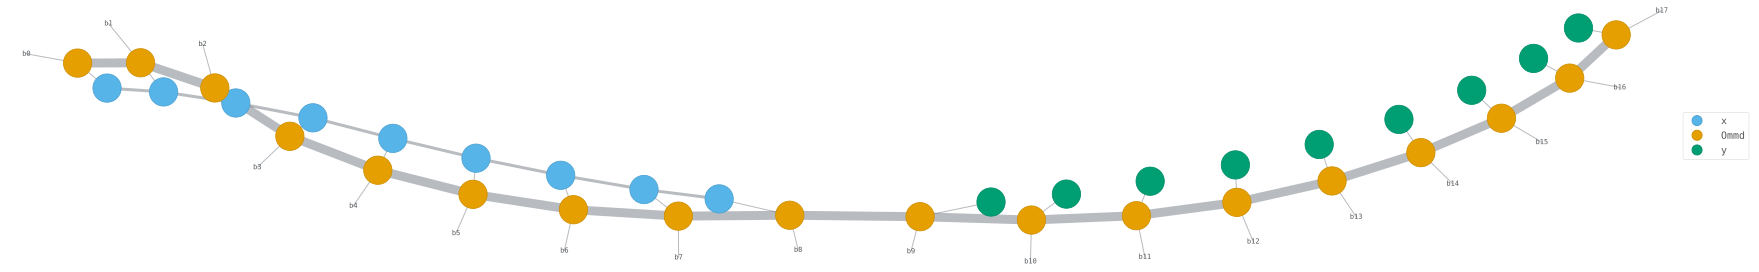

+0.064295801950 [best: +0.064295801950] :  80%|████████  | 8/10 [00:08<00:02,  1.18s/it]

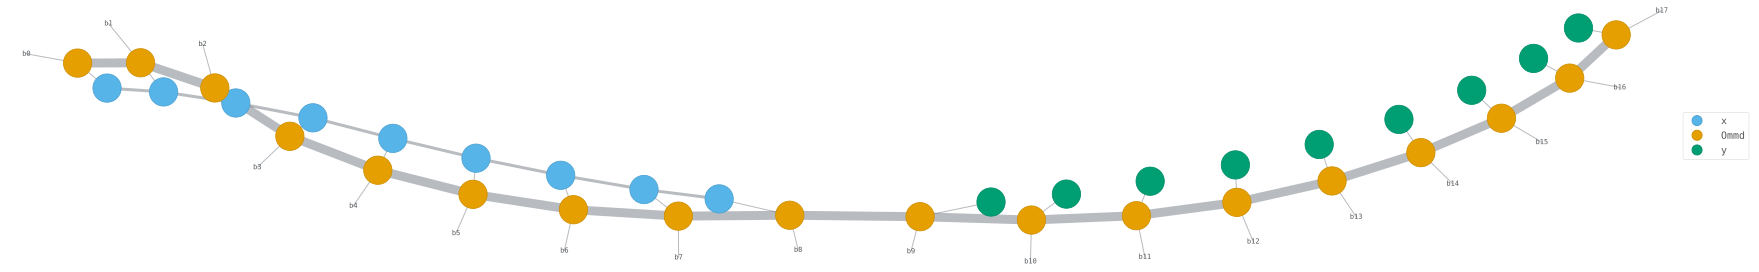

+0.054446356707 [best: +0.054446356707] :  90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

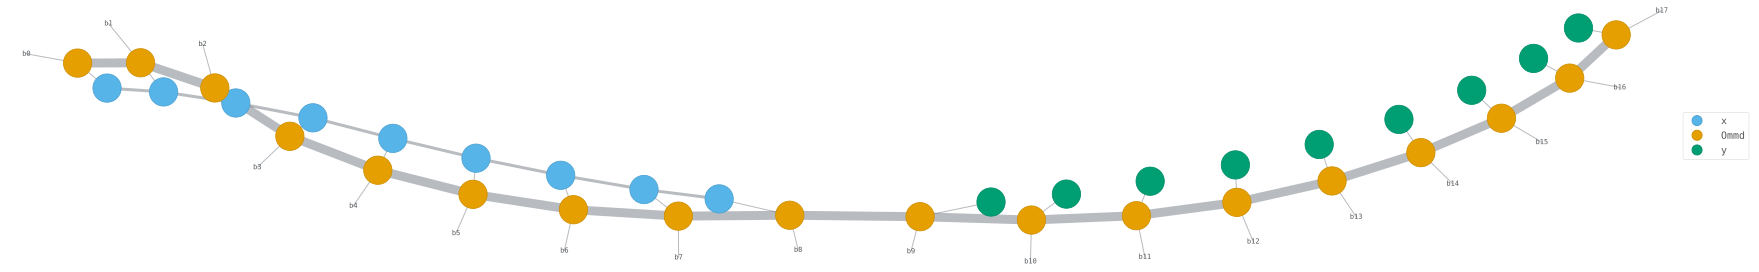

+0.046417744175 [best: +0.046417744175] : 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

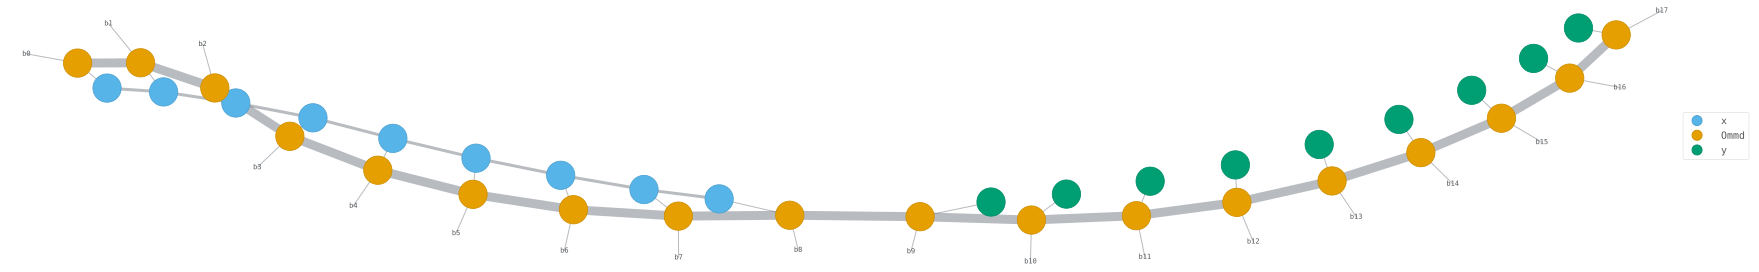

+0.039842122166 [best: +0.039842122166] : : 11it [00:12,  1.12s/it]                      


In [228]:
psi_opt = tnopt.optimize(10)